# Inference with Models

An X-ray transient monitor has detected a new source. This is exciting! However, we don't know what it is, so we'd like to know what Fermi observed. For the purpose of this toy problem, we are going to ignore the question of whether Fermi observed the source at all or not (although that's an important problem, too!). For the purpose of this tutorial, we'll assume we know that Fermi observed something significant! Hooray!

What we'd like to know: what are the details of the source that Fermi observed? We'd like to do a multi-wavelength Spectral Energy Distribution, so knowing the total flux that Fermi observed would be very useful to help piece that together. We'd also like to know the precise position of the source. 

The purpose of the following analysis is to infer the physical properties (its flux and its position) so that we can use these to help us understand the nature of the new, exciting source we've observed. 

## Different Examples

Group 1: Gaussian PSF, weird prior, Poisson likelihood
Group 2: Gaussian PSF, good prior, Gaussian likelihood
Group 3: non-Gaussian PSF, good prior, Poisson likelihood


* broad LIGO prior (good prior)
* narrow, but mis-matched X-ray prior (bad prior)

* Gaussian likelihood
* Poisson likelihood

* PSF Gaussian
* PSF not Gaussian 

Data is always the same, except for the case where the PSF is not actually Gaussian. 

## Concepts

* (maximum) likelihood estimation
* adding priors
* posterior computation with optimization and MCMC
* (posterior predictive) model checking
* checking your assumptions

## Imports

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

# I like using the plotting library seaborn to set style defaults
# If you don't have seaborn or don't want to use it, comment out the 
# two lines below
import seaborn as sns
sns.set_style('white')

import numpy as np
import scipy.stats

Let's generate some data from a multivariate normal. We assume our PSF is Gaussian and normally distributed, and also round (so there's only one width parameter, and the covariance matrix is diagonal by default:

In [2]:
# true parameters
true_pos = [125, 154]
true_amp = 12000
true_std = 12.5
true_bkg = 0.5

# image size
img_size = 300

We need to generate a grid of numbers for the x and y axes:

In [3]:
x, y = np.meshgrid(np.linspace(0,img_size, num=img_size),np.linspace(0,img_size,num=img_size))

Let's define a function for a Gaussian PSF. We'll also include a constant for the background:

In [4]:
def gauss_psf(x, y, amp, mean1, mean2, std, bkg):
    norm_term = amp / (2. * np.pi * std**2.)
    exp_term = np.exp(-((x - mean1)**2. / (2. * std**2.) + (y - mean2)**2. / (2. * std**2.)))
    return norm_term * exp_term + bkg

In [5]:
model_flux = gauss_psf(x, y, true_amp, true_pos[0], true_pos[1], true_std, true_bkg)

<IPython.core.display.Javascript object>


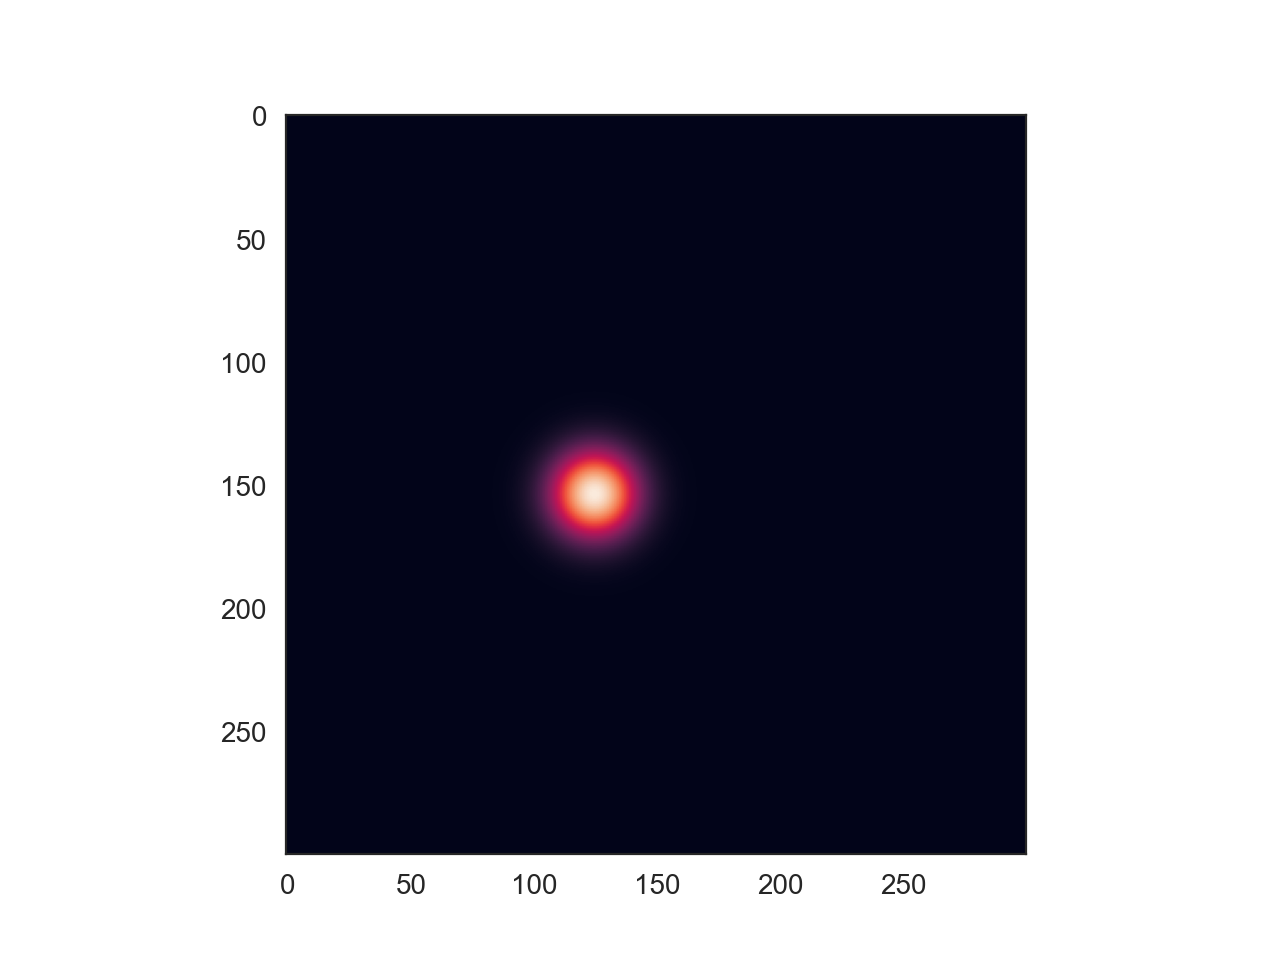

In [6]:
plt.figure()
plt.imshow(model_flux)

In [7]:
np.max(model_flux)

12.706948216994464

In [8]:
poisson_flux = np.random.poisson(model_flux)

<IPython.core.display.Javascript object>


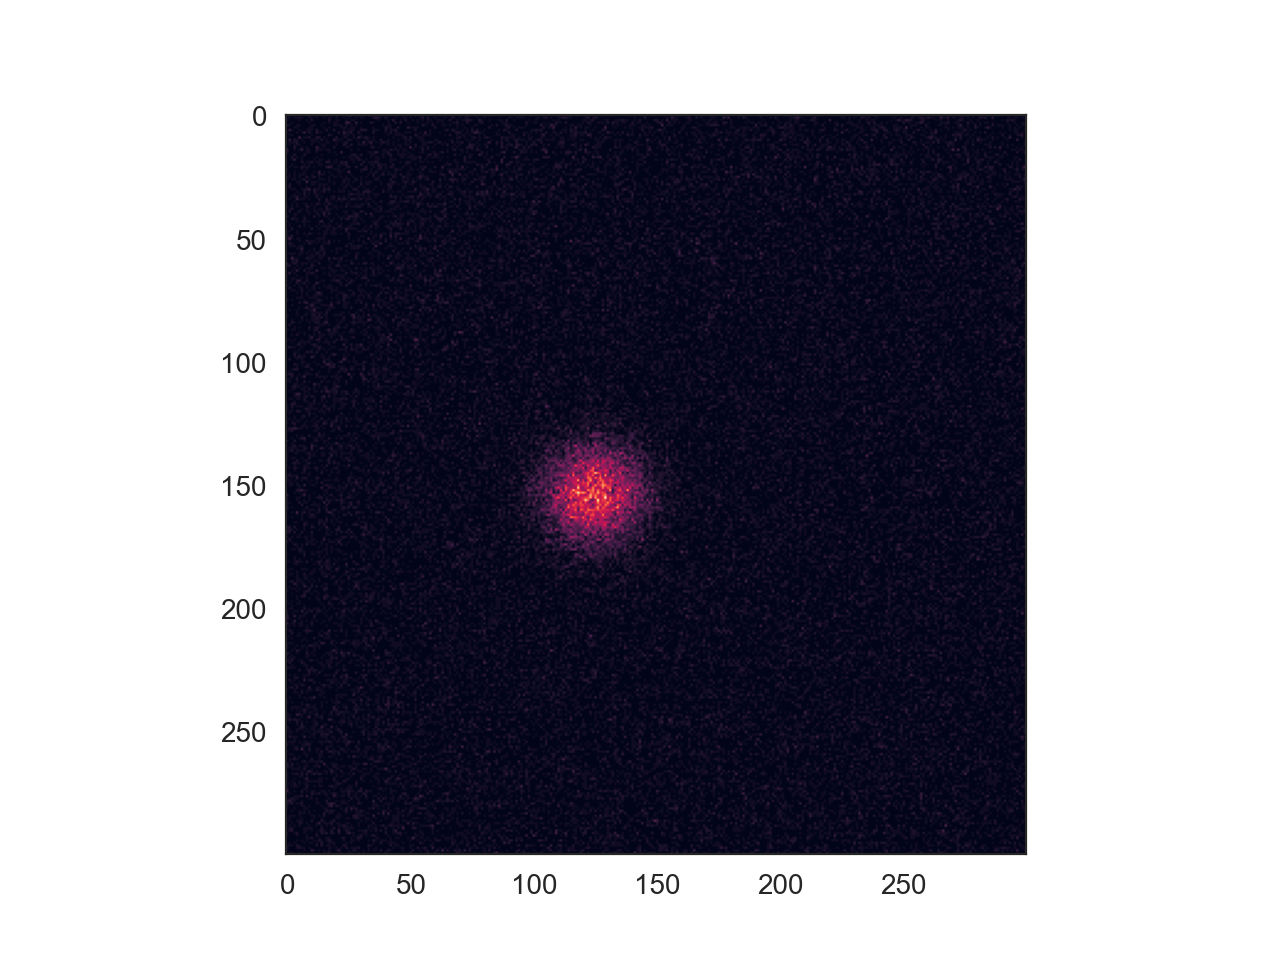

In [9]:
plt.figure()
plt.imshow(poisson_flux)

In [10]:
np.savetxt("fermi_toyproblem1.dat", poisson_flux)

In [85]:
model_flux2 = gauss_psf(x, y, true_amp*2.5, true_pos[0], true_pos[1], true_std*2, true_bkg) + \
                gauss_psf(x, y, true_amp/10.0, true_pos[0], true_pos[1], true_std/3.0, 0.0)

<IPython.core.display.Javascript object>


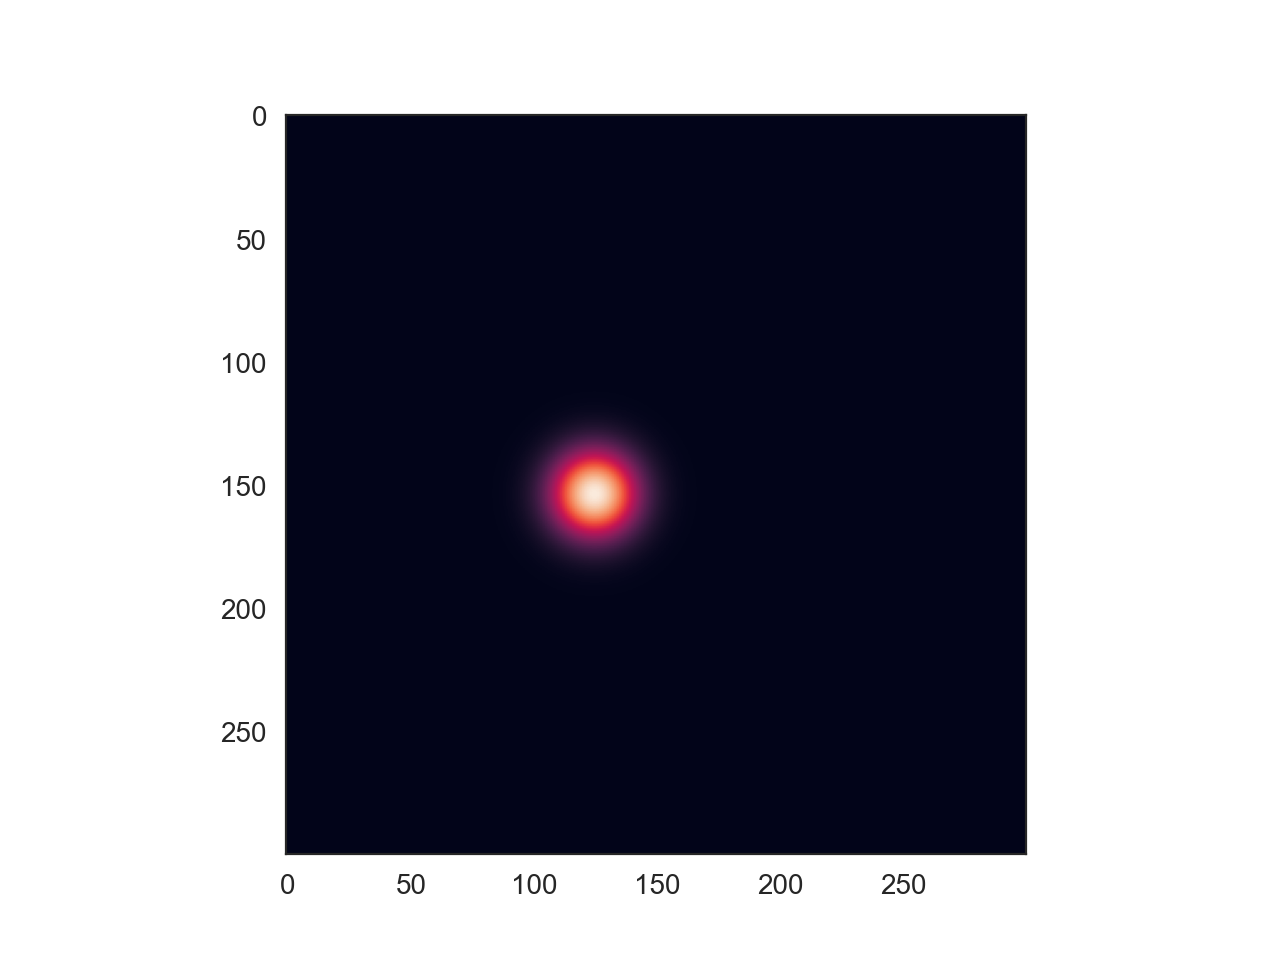

In [86]:
plt.figure()
plt.imshow(model_flux)

In [87]:
poisson_flux2 = np.random.poisson(model_flux2)

<IPython.core.display.Javascript object>


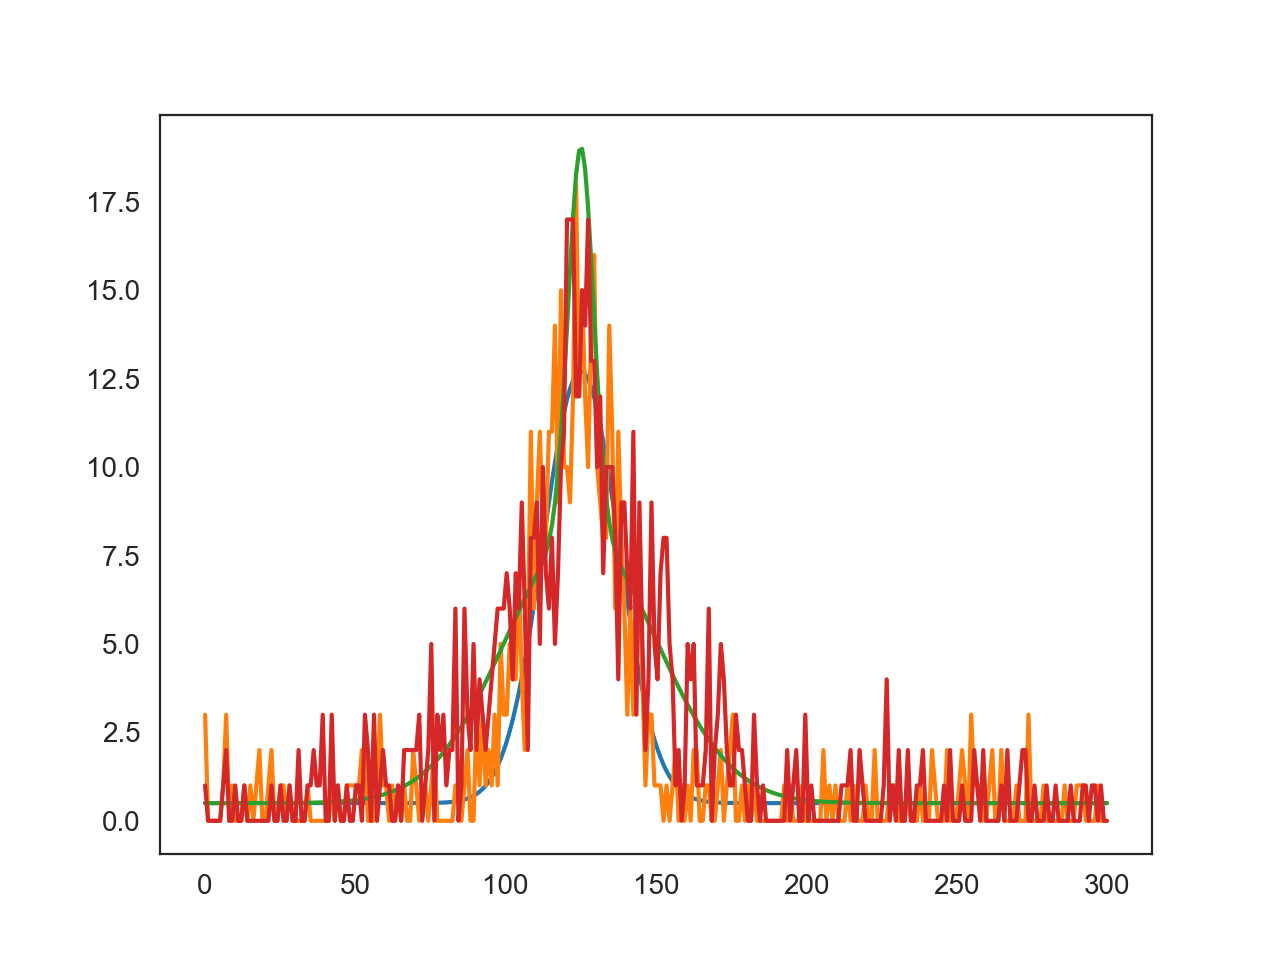

In [88]:
plt.figure()
plt.plot(x[0], model_flux[154])
plt.plot(x[0], poisson_flux[154])
plt.plot(x[0], model_flux2[154])
plt.plot(x[0], poisson_flux2[154])

In [89]:
np.savetxt("fermi_toyproblem2.dat", poisson_flux)

In [90]:
np.savetxt("fermi_toyproblem3.dat", poisson_flux2)

Okay, cool, we have some data. Let's plot a slice through that data?

<IPython.core.display.Javascript object>


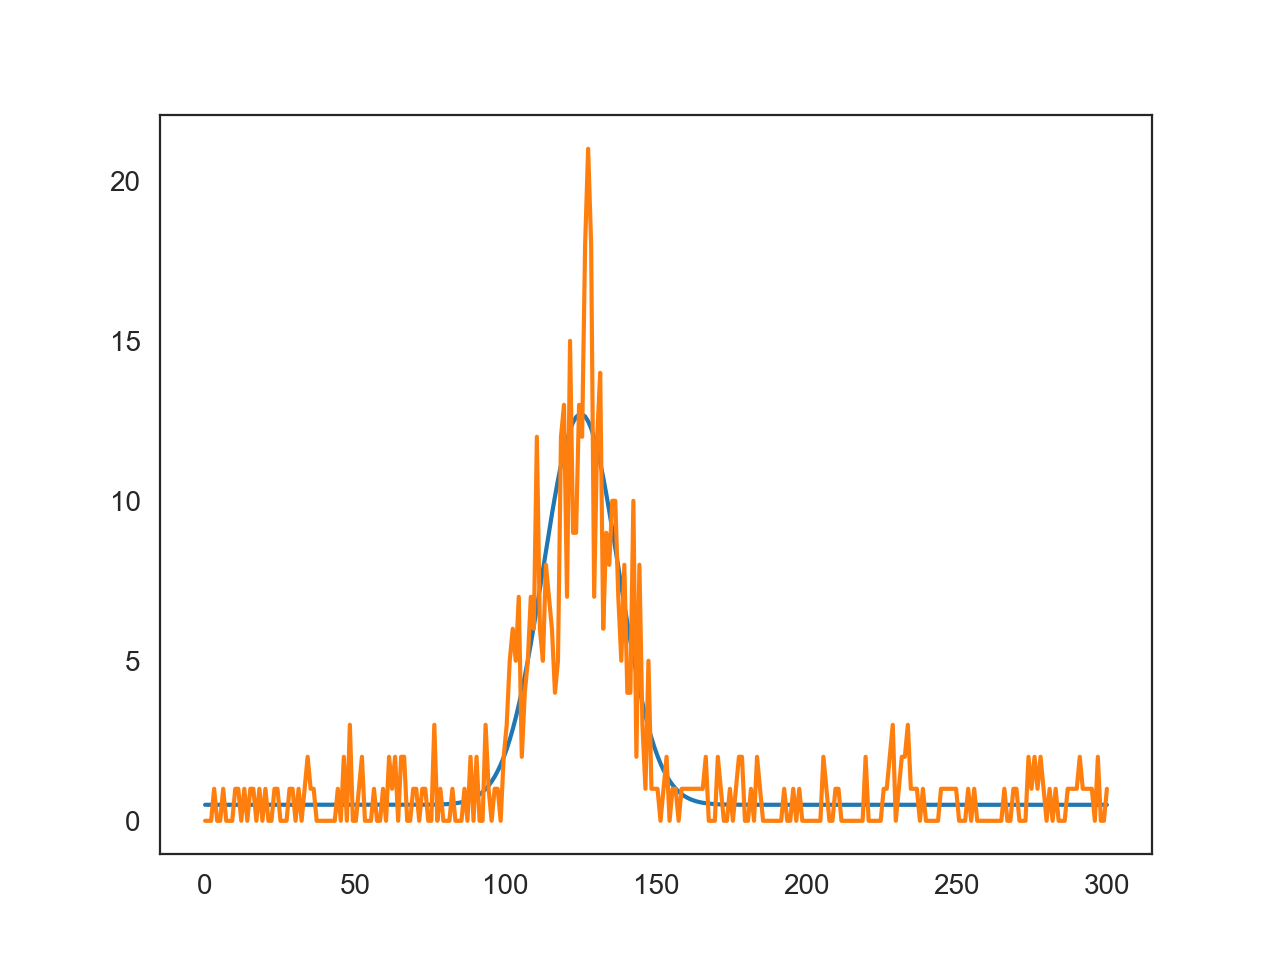

In [181]:
plt.figure()
plt.plot(x[0], model_flux[154])
plt.plot(x[0], poisson_flux[154])

Okay, that looks about right. Now we want to write down a likelihood:

In [182]:
logmin = 1000000000000.

def loglikelihood(t0, x, y, poisson_flux):

    ## call the function you've put in __init__, use parameter set t0 and
    ## the x-coordinate grid to compute the model image
    model_counts = psf(x, y, *t0)

    ## compute Poisson likelihood
    loglike = -np.sum(model_counts) + np.sum(poisson_flux*np.log(model_counts))\
                -np.sum(scipy.special.gammaln(poisson_flux + 1))

    ## deal with NaN and inf values of the log-likelihood
    ## if either of these is true, choose a ridiculously small value
    ## to make the model *really* unlikely, but not infinite

    if np.isnan(loglike):
        loglike = -logmin
    elif loglike == np.inf:
        loglike = -logmin

    return loglike

In [183]:
true_pars = [true_amp, true_pos[0], true_pos[1], true_std, true_bkg]

In [184]:
loglikelihood(true_pars, x, y, poisson_flux)

-87430.36875969908

## Estimating the "Best" Parameters

The likelihood gives us an estimate for the probability of having recorded our observing data given some underlying "true" model and model parameters. However, we don't know what these true parameters are; that's exactly what we're trying to estimate! We can do so by stepping through different parameter values, and recording the likelihood of having observed the data, given the assumption that these parameters are true. We then pick the parameters that give us the highest likelihood value as the "best" parameters given our observed data. This is called **maximum likelihood estimation**. 

It is a somewhat subtle, but important distinction that the likelihood is *not* a probability distribution of the parameters, but of the data. It assumes that we are drawing random realizations from an underlying model, given a model and parameters that are known to be true. While you can make meaningful statistical inferences about a scientific problem this way, there are some cases where the structure of the likelihood as a probability of the data makes your life a bit harder. Later, we will talk about how Bayes' theorem gives you a convenient way to flip the probabilities around, and get a probability distribution of the parameters given an observed data set. 
[This paper]() by David W. Hogg gives a great intuitive introduction to the topic of why this matters.


### Optimization

So how do we search for the maximum likelihood in practice? One thing you can do is make a grid of parameters, calculate the likelihood for each one, and then simply pick the largest one. This can work great, but also has some significant drawbacks: for example, this might work great when you have only one or two parameters to estimate. Once you have more than that, however, this becomes very unwieldy and computationally expensive, because you have to generate a grid over as many dimensions as you have parameters. Secondly, what should the resolution of your grid be? What if you have a likelihood that's zero almost everywhere except for a small region of parameter space? If you make your grid too coarse, you run the risk of never actually getting close to the maximum likelihood at all. If you make it fine-grained, you are wasting a lot of computational time on regions of parameter space that are entirely uninteresting. 

One common way is to use **optimization**. Optimization algorithms usually start at a single point in parameter space, and then try to find intelligent ways to pick the next step where to estimate the likelihood. Often, this involves calculating the *gradient* of the likelihood to inform the algorithm where to step next. There's a wide range of different algorithms out there, suited to a number of different problems, but one good place to start is the `scipy.optimize` sub-module. 

One subtlety about optimization is that while we are trying to find the parameters where the likelihood has its *maximum*, most optimization algorithms are in practice *minimization* routines. That is, they attempt to find the minimum of a function. 

In practice, this is easily dealt with by defining the inverse of the log-likelihood, and then using this in our minimization algorithm:

In [185]:
negloglike = lambda pars, x, y, poisson_flux: -loglikelihood(pars, x, y, poisson_flux)

One crucial component of optimization is picking good starting parameters. Bad starting parameters can get you stuck in local optima, that can be far away from the true optimum. The problem is that you don't know what the true optimum is, so you can't really know whether you got stuck in a local optimum. One thing you can do is start the optimization multiple times from different starting parameters, and then pick the outcome that has the highest value for the maximum likelihood. However, for some problems it's also possible to pick reasonably good starting parameters from the data itself.

**Exercise**: Can you think of ideas for how to pick starting parameters for the optimization? 

**Solution**: 

Let's pick the position where the data has its maximum as a starting parameter for the position: 

In [194]:
poisson_flux.shape

(300, 300)

In [208]:
start_pos = np.unravel_index(poisson_flux.argmax(), poisson_flux.shape, order="F")

<IPython.core.display.Javascript object>


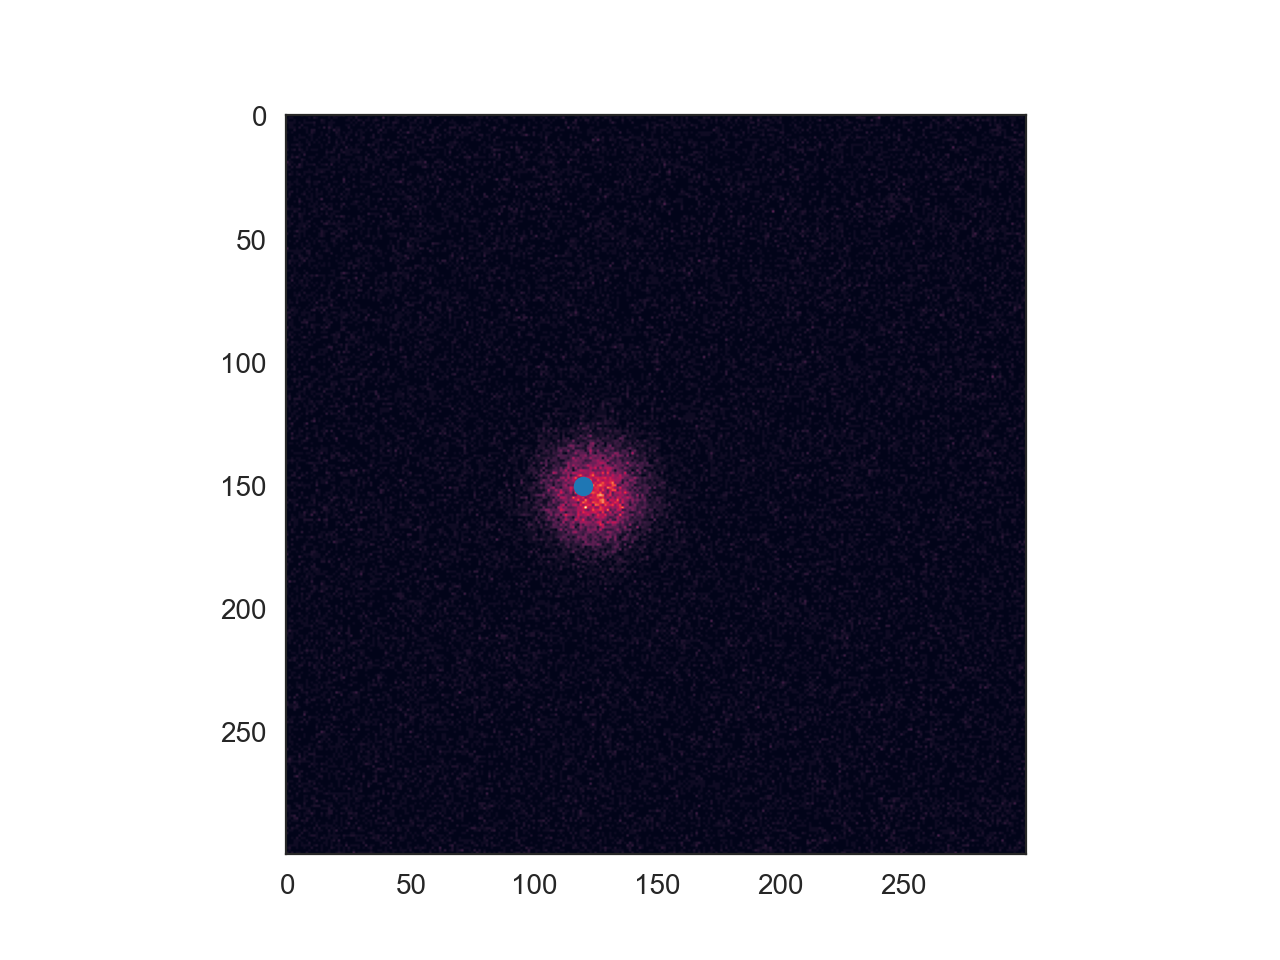

In [209]:
plt.figure()
plt.imshow(poisson_flux)
plt.scatter(*start_pos)

The amplitude is the integrated flux across the image, minus the background. So for the background, we're going to take a slice of the image that doesn't have source in it, and calculate the mean:

In [214]:
start_bkg = np.mean(poisson_flux[:100, :100])

Now we can calculate the background flux in the whole image, and subtract that from the total flux in the image:

In [217]:
start_amp = np.sum(poisson_flux) - poisson_flux.size * start_bkg

For the width, let's plot a slice through the image at the estimated starting position and guess by eye:

In [218]:
start_pos

(120, 150)

<IPython.core.display.Javascript object>


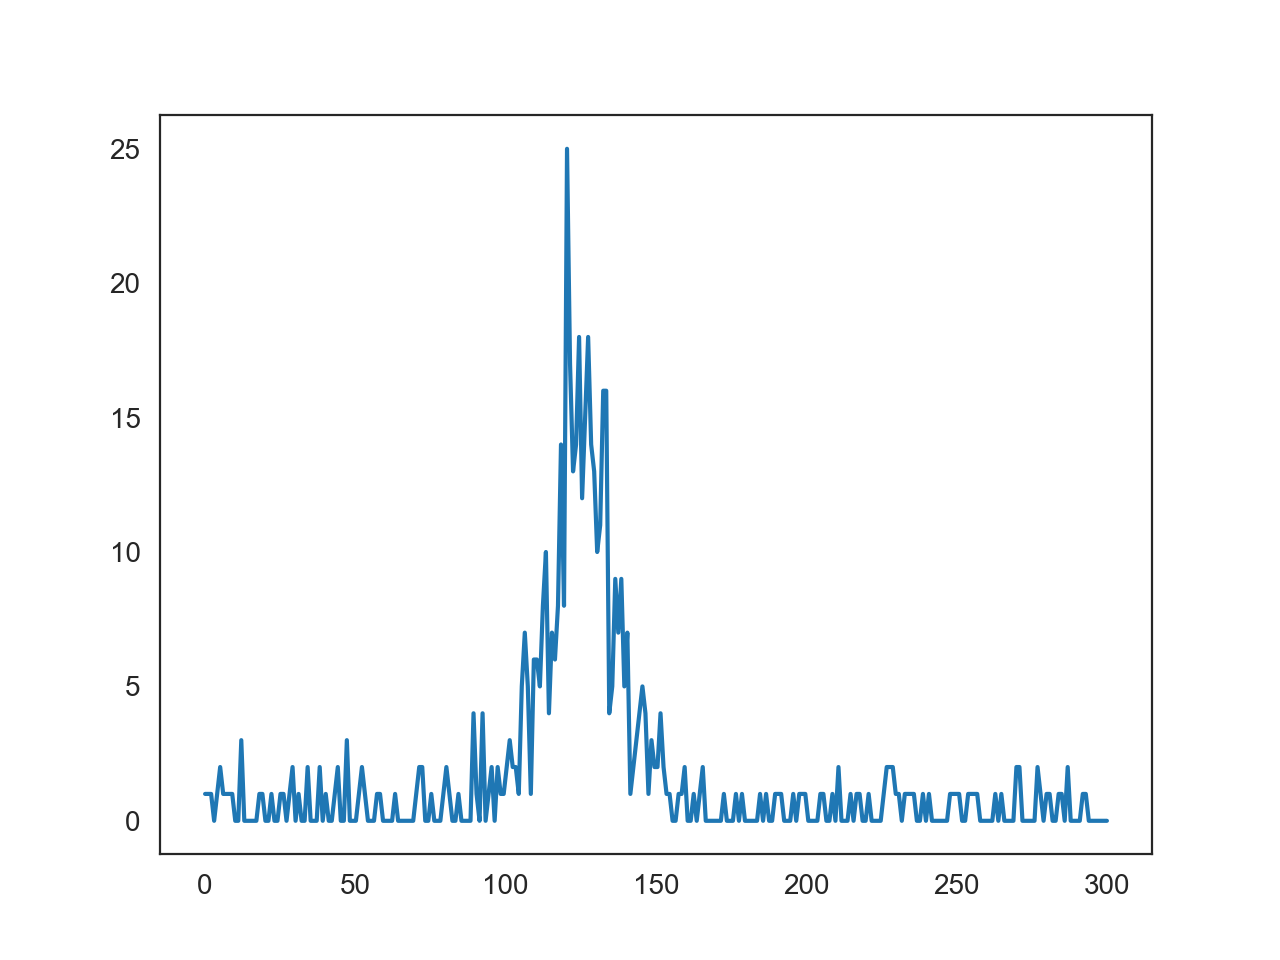

In [230]:
plt.figure()

plt.plot(x[0], poisson_flux[start_pos[1],:])

So it looks like the overall size of the Gaussian is about 50 pixels. Let's half that to get a rough estimate on the full width at half maximum. Then we need to half that again to get an estimate on the standard deviation of the Gaussian function we're using. 

In [231]:
start_width = 50/4.0

Let's pull all of these together into a single set of parameters:

In [232]:
start_pars = [start_amp, start_pos[0], start_pos[1], start_width, start_bkg]
print(start_pars)

[12250.0, 120, 150, 12.5, 0.5018]


Okay, now we've got all of our starting parameters. 

Let's run `scipy.optimize.minimze` to see what we get:

In [279]:
res = scipy.optimize.minimize(negloglike, start_pars, args=(x, y, poisson_flux), method='bfgs',tol=1)

The output of `scipy.optimize.minimize` is an object with a wealth of useful information. 

Here are some important ones.

You'll want to pay attention to the attributes `success` and `message`, which give you information about whether the algorithm thinks it's succeeded to find the minimum of the function, and gives you some information (though it's usually pretty arcane), why it did or did not:

In [240]:
print(res.success)
print(res.message)

True
Optimization terminated successfully.


In our case, the algorithm terminated successfully. Hooray!
When this is not the case, the error messages can usually be pretty arcane and hard to debug. It's then worth hunting around the internet for help on what they mean and what the issues might be.

The `fun` attribute gives you the function value at termination. This is the maximum likelihood we're looking for (or at least its inverse:

In [286]:
print("Maximum likelihood: " + str(-res.fun))

Maximum likelihood: -87425.9532957931


The other useful information you'll want is stored in the `x` attribute, which has the parameters at which the optimizer has found the maximum likelihood:

In [287]:
print("Best-fit parameters: " + str(res.x))

Best-fit parameters: [1.22499519e+04 1.25133049e+02 1.54039466e+02 1.23351370e+01
 5.04398263e-01]


Let's take a look at the best-fit model:

In [288]:
model_fit = psf(x, y, *res.x)

<IPython.core.display.Javascript object>


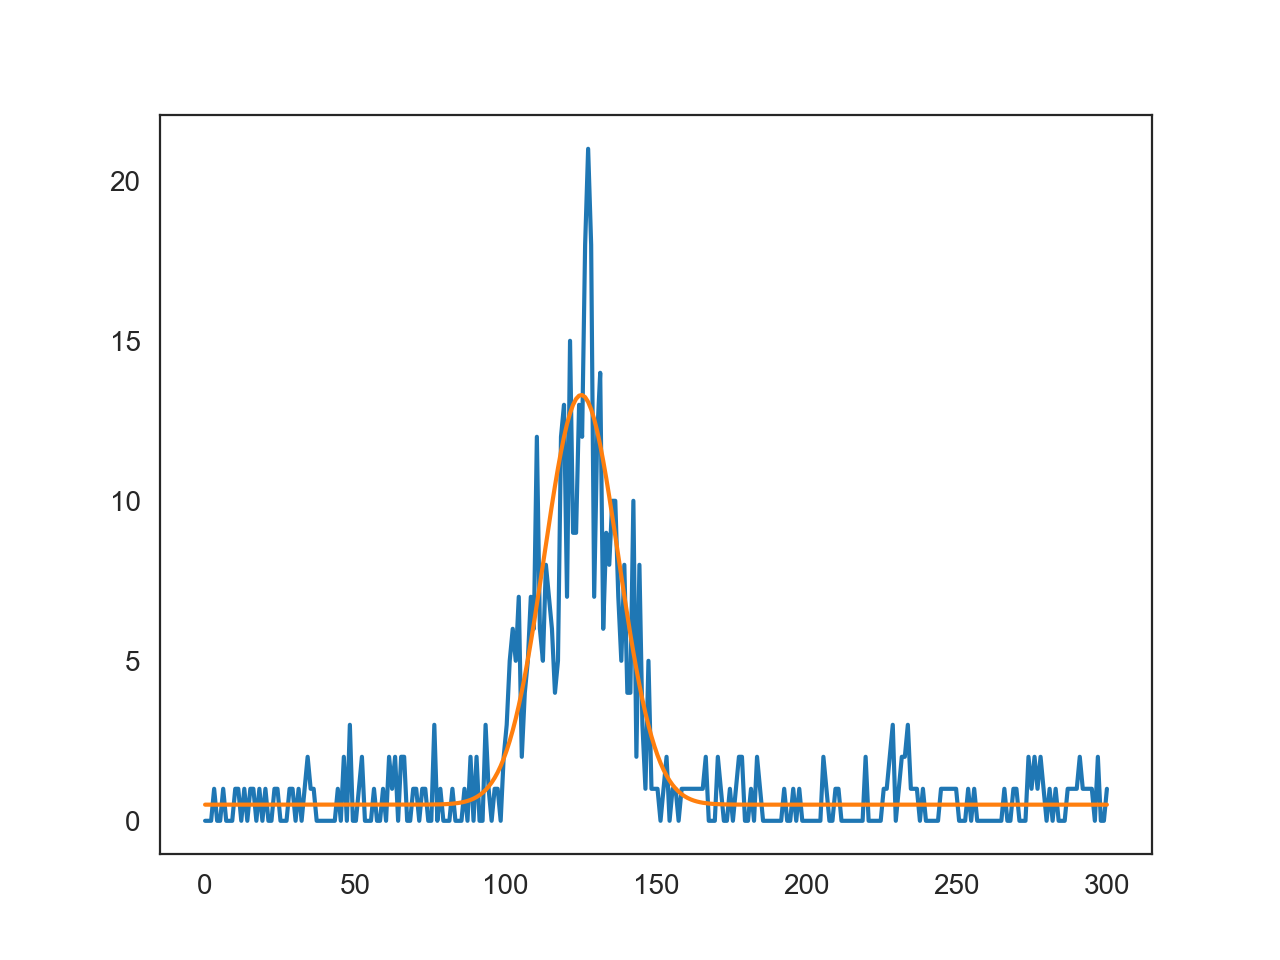

In [289]:
plt.figure()
plt.plot(x[0], poisson_flux[154])
plt.plot(x[0], model_fit[154])



That looks not bad! 

**Exercise**: `scipy.optimize.minimize` has a number of available algorithms. Do all of them give you the same output? Do you get noticeably different parameters? Do you think they are better or worse than the standard BFGS algorithm we've chosen above?

### Parameter Uncertainties

We'd also like to know the uncertainties on our parameters. One estimate you can gain from the optimization process is to use the *inverse Hessian*. Many algorithms use the first and second derivatives of the likelihood as information on where to step next. We can use these estimates to calculate a measure of the width of the likelihood, which in turn can be interpreted as uncertainties on the parameters. 

**Note**: Not all minimization algorithms return the *inverse Hessian*, which you can interpret as a covariance matrix. If you are using an algorithm that doesn't, you can still often calculate a numerical approximation (there's a routine e.g. in the `statsmodels` package). 

**Important**: The calculation of uncertainties this way makes strong assumptions about the shape of the likelihood, which may or may not be appropriate for your problem. In particular, it makes the assumption that the likelihood is approximately Gaussian in shape (and so your uncertainties are symmetric). Some problems, especially those with complex physical models, may have more complicated shapes for the likelihood, or a likelihood that is asymmetric. In this case, the uncertainties derived in this way are not reliable. 

In [295]:
print("Parameter uncertainty estimates: " + str(np.sqrt(np.diag(res.hess_inv))))

Parameter uncertainty estimates: [1.00030641 0.13190468 0.13100875 0.08068592 0.00242409]


## Priors

Let's assume that the initial transient detection came from the LIGO gravitational wave observatory. This is exciting, because electromagnetic counterparts to gravitational wave sources are scientifically very interesting. The LIGO observatory can't locate sources very well: their detection maps often stretch across a big stripe of the sky. However, they do give us *some* information about where the source we are interested in should be located on the sky.

For the purpose of this toy exercise, we're going to assume the following position estimates from LIGO:
x = 150 +/- 20
y = 180 +/- 100

**Exercise**: Can we incorporate this information as a prior? What kind of shape would you choose for your prior?



**Solution**: 

This is what's called an **informative prior**. Informative priors are those where we have meaningful information prior to looking at the data to help us constrain the problem. Note that priors, in general 

Let's assume that LIGO told us their positional probabilities are approximately Gaussian, so we can pick a Gaussian prior for the positional parameters:

In [305]:
pos1_prior = scipy.stats.norm(150, 20).logpdf
pos2_prior = scipy.stats.norm(180, 100).logpdf

We unfortunately don't know much about the amplitude in advance. For this parameter, we'll need what's called an **uninformative prior**. These are priors that encode our lack of information. Naively, you might expect that an uninformative prior would assign the same probability to each possible value across a range. However, for some parameters, this turns out not to be a good, uninformative choice. This is especially true for parameters that can range over multiple orders of magnitude. The problem here is that when you assign the same probability to all values, then the probability of a value between 0.1 and 0.2 is *much* smaller than the probability of a value between 1 and 2. To avoid this, we use what's called a *Jeffrey's prior*, which assigns equal probability to the *logarithm of the parameter.

In [313]:
logamp_prior = scipy.stats.uniform(-2, 12).logpdf

Finally, we also need a prior for the width. For this parameter, let's assume we know from the Fermi documentation that the PSF is about 12 +/- 3 pixels. Again, we'll translate this to a Gaussian prior.

The prior for the background parameter is also Gaussian, and based on our (presumed) knowledge of the gamma-ray sky. For this, we have a prior estimate of 0.5 +/- 0.1.

**Exercise**

Write down the log-priors for the width and the background:

**Solution**

In [300]:
width_prior = scipy.stats.norm(12, 3).logpdf
bkg_prior = scipy.stats.norm(0.5, 0.1).logpdf

Note that in principle, we could construct more complicated priors. For example, imagine that we know that the width of the PSF depends on the incoming flux (so on our amplitude parameter). We could construct a prior where the width prior actually depends on the amplitude parameter. 

However, today we'll forge ahead with the priors we have. According to Bayes' rule, the prior probability density for all parameters is the product of the individual densities. Because we've designed them as logarithms above, this then becomes a sum.

**Exercise**

Complete the function below to construct the prior of the whole set of parameters.
Make sure to account for the fact that the amplitude prior is defined on the *logarithm* of the amplitude parameter, not on the parameter itself.

In [ ]:
def logprior(pars):
    amp = pars[0]
    pos1 = pars[1]
    pos2 = pars[2]
    width = pars[3]
    bkg = pars[4]
    
    lp = pos1_prior(pos1) + # complete this function
    
    return lp

**Solution**



In [316]:
def logprior(pars):
    amp = pars[0]
    logamp = np.log(amp)
    pos1 = pars[1]
    pos2 = pars[2]
    width = pars[3]
    bkg = pars[4]
    
    lp = logamp_prior(logamp) + pos1_prior(pos1) + pos2_prior(pos2) + width_prior(width) + bkg_prior(bkg)
    return lp

In [317]:
logprior(true_pars)

-13.386529326711727

## The Posterior

We are now set up to calculate the posterior probability density. The posterior density is essentially the product of the likelihood and prior (except for a normalization factor, which is important in the context of model comparison, but which we can safely neglect for parameter estimation). 

Again, defining our quantities in terms of their logarithm means that we can add them together:

In [326]:
def logposterior(pars, x, y, poisson_flux):
    lpost = loglikelihood(pars, x, y, poisson_flux) + logprior(pars)
    
    if np.isnan(lpost):
        lpost = -logmin
    elif lpost == np.inf:
        lpost = -logmin
        
    return lpost

In [329]:
logposterior(true_pars, x, y, poisson_flux)

-87443.7552890258

In [330]:
logposterior(start_pars, x, y, poisson_flux)

-88625.77337024479

## Estimating the Posterior

In only very rare special cases, the posterior probability density is analytically tractable, that is, you can write down a functional form for it. This is particularly the case if you have defined what are called *conjugate* priors, which are priors that specifically make the posterior analytically tractable. Being able to cast your priors into a conjugate form is always an advantage, but rare in practice, especially when your problem has many parameters. You can find conjugate priors for commong likelihoods in various forms online. 

Alternatively, you can do optimization on the posterior the same way that we've done on the likelihood. This is called *maximum a posteriori estimation* and allows you to get quick parameter estimates that take our prior knowledge into account.

**Exercise for at home**

Write down the code to do a maximum-a-posteriori estimation in the same way we've done above with the likelihood. Start from different positions, and see how this changes the result. What happens if you pick starting values outside of the support of the prior (e.g. out of the bounds of flat priors, or very far out in the wings of a Gaussian prior)?

**Solution**

We can reuse a bunch of code from above, but like with the likelihood, we're interested in the maximum of the posterior distribution. Because optimization routines use minimization algorithms, we need to define the inverse of the log-posterior:

In [350]:
negpost = lambda pars, x, y, poisson_flux: -logposterior(pars, x, y, poisson_flux)

In [355]:
res = scipy.optimize.minimize(negpost, start_pars, args=(x, y, poisson_flux), method='bfgs', tol=0.1)

In [356]:
res

      fun: 87439.32437773202
 hess_inv: array([[ 1.03140035e+00,  8.40763288e-03,  6.20184150e-03,
        -7.54229764e-03,  7.53524169e-06],
       [ 8.40763288e-03,  1.70238080e-02,  4.64655133e-04,
        -4.24206542e-05,  2.42016491e-07],
       [ 6.20184150e-03,  4.64655133e-04,  1.70486836e-02,
         5.18355510e-05, -2.49432452e-08],
       [-7.54229764e-03, -4.24206542e-05,  5.18355510e-05,
         5.96481701e-03, -1.89270963e-05],
       [ 7.53524169e-06,  2.42016491e-07, -2.49432452e-08,
        -1.89270963e-05,  5.87232668e-06]])
      jac: array([ 0.01367188, -0.00488281, -0.00390625,  0.01757812,  0.03222656])
  message: 'Optimization terminated successfully.'
     nfev: 90
      nit: 9
     njev: 15
   status: 0
  success: True
        x: array([1.22499357e+04, 1.25134657e+02, 1.54039838e+02, 1.23342727e+01,
       5.04396832e-01])

## Markov Chain Monte Carlo

However, there's a different way to characterize the posterior probability density. One advantage of writing down a posterior is that it gives us probability distributions over *parameters*, which we're interested in, especially if these distributions are not as well-behaved as required by typical optimization to give meaningful estimates.

Again, we could generate a grid and then plot the results. However, the same problems surrounding how to pick the grid size and computational inefficiencies still apply. 

Instead, what we want is an algorithm that explores parameter space relatively efficiently, but is also not concerned *just* with finding the maximum value, but rather can give us a fuller description of the probability distribution. 

Enter Markov Chain Monte Carlo! A full tutorial on MCMC is beyond the scope of this set of exercises, so if you're interested in more details, take a look at [this paper](https://iopscience.iop.org/article/10.3847/1538-4365/aab76e/meta). For the purposes of today, here's what you need to know.

MCMC describes a set of algorithms that define rules to intelligently step in parameter space, with the goal to explore the probability distribution. In the basic concept, starting from some point in parameter space, the algorithm will pick a new point according to some proposal distribution $q(\theta)$. It then compares the posterior probability of the new point with the posterior probability of the old point. If the ratio of the two $r$ is larger than one, the new point is kept. If it's smaller than 1, then the new point will be accepted with probability $r$ and rejected with probability $1-r$. If it's not accepted, the original point will be duplicated, and the procedure starts again. If the new point is accepted, it will become the next point to jump from according to the proposal distribution $q$. In this way, we build up a list of points--or more commonly referred to as *samples*--that is denser in regions of high probability and less dense in regions of low probability. If you run this algorithm for long enough (ideally, to infinity, but who has time for that?), the samples will provide a good approximation to the posterior density. 

The most well-known MCMC algorithm is the [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm). There are also a number of related methods like Nested Sampling, Slice Sampling and Hamiltonian Monte Carlo, which all approach the sampling problem somewhat differently.  

**Exercise for at home**

Write your own Metropolis-Hastings sampler! There are better algorithms for most problems (though don't underestimate how powerful Metropolis-Hastings can be on the right problem!), but writing your own sampler is invaluable for understanding some of the tricky problems with samplings. I encourage you to write your own, and compare it to samplers available in existing software packages. 

We're not going to write our own sampler here, but rather use an implementation in the popular package `emcee`. If you don't have that package installed, you can do so by typing `pip install emcee` into the empty cell below:

`emcee` works somewhat similar to the Metropolis-Hastings algorithm outlined below, but includes some important improvements. It also doesn't run a single sampling process as we've outlined above, but rather many of them simultaneously. Let's set this up:

In [360]:
import emcee

In [368]:
# number of parallel sampling processes
nwalkers = 32

### number of dimensions for the Gaussian seeds (= number of parameters)
ndim = len(res.x)

We need to sample some random starting positions. We're going to do that using the best-fit optimization result above: 

In [369]:
### sample random starting positions for each of the walkers
p0 = [np.random.multivariate_normal(res.x,res.hess_inv) for i in range(nwalkers)]

In [370]:
### initialize sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=[x, y, poisson_flux])

While we made a good guess that the starting parameters are near the true properties of our source, we don't know that in practice. So initially, it's possible that our sampling processes will be far away from a region of high probability. While MCMC algorithms are designed such that they will (ideally) eventually move to regions of high probability, they might initially not be. This means that the first steps in our process will not accurately reflect the true posterior distribution.

For this reason, we generally throw away the initial $k$ steps in our chain, which is called "burn-in". After that, we hope that the chain is *burned-in*, that is, it has moved to our posterior distribution. Let's try this out:

In [371]:
burnin_samples = 1000
pos, prob, state = sampler.run_mcmc(p0, burnin_samples)

This might take a few minutes to run, depending on your computer!

One useful check is to plot the all the samples from all the processes. If there are large trends in the samples over time, that is, if the processes wander about, then the processes is likely not burned in yet, and we need to run it for longer. If the chains look like random noise, they might be burned in and good to go.

**Exercise**

Plot the chains for each parameter. Are they stable around some value? Do they wander about in parameter space? 

Hint: You can get the samples using the command `sampler.get_chain()`

**Solution**

In [376]:
samples = sampler.get_chain()

In [377]:
samples.shape

(1000, 32, 5)

<IPython.core.display.Javascript object>


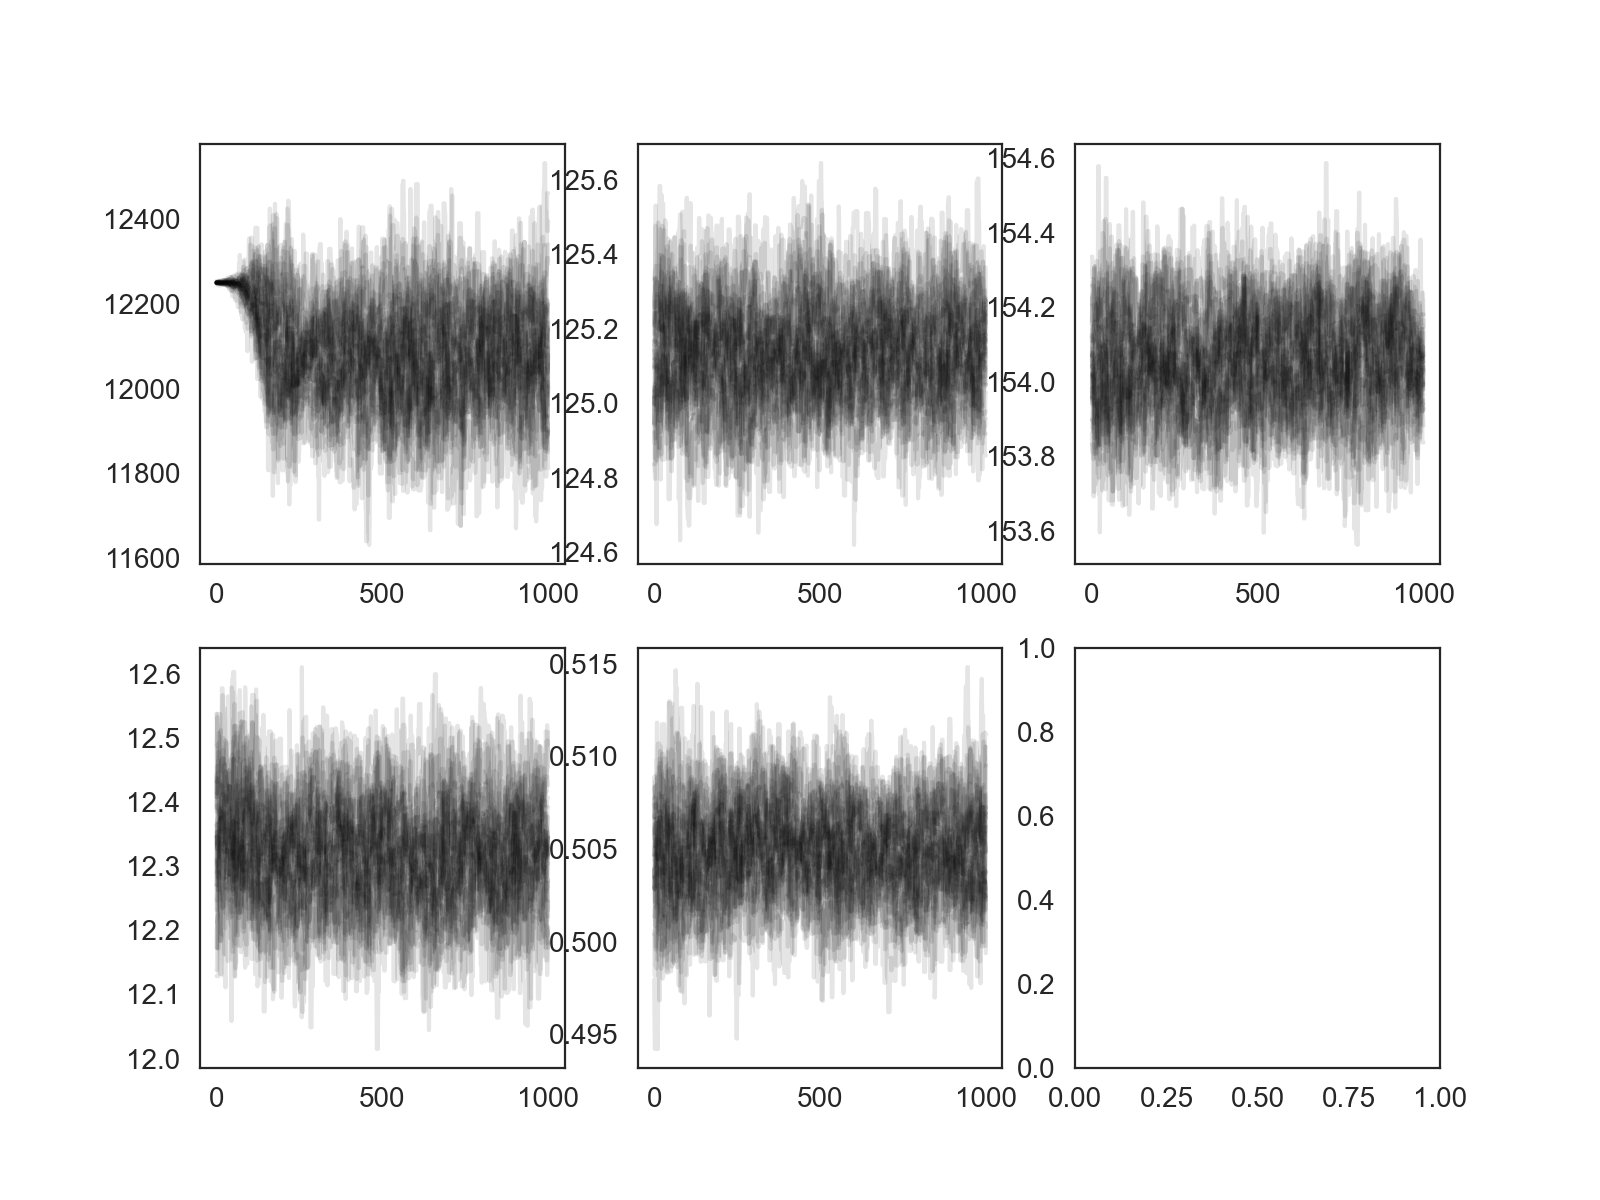

In [380]:
fig, axes = plt.subplots(2, 3, figsize=(8,6))

axes = np.hstack(axes)

for i in range(len(res.x)):
    axes[i].plot(samples[:,:,i], alpha=0.1, color="black")

This looks not bad!
Let's run this for longer, and then throw away the first thousand or so samples.

In [386]:
_,_,_ = sampler.run_mcmc(pos, 1000, progress=True)

100%|██████████| 1000/1000 [01:50<00:00,  9.06it/s]


In [387]:
samples = sampler.get_chain()

In [389]:
samples.shape

(3000, 32, 5)

<IPython.core.display.Javascript object>


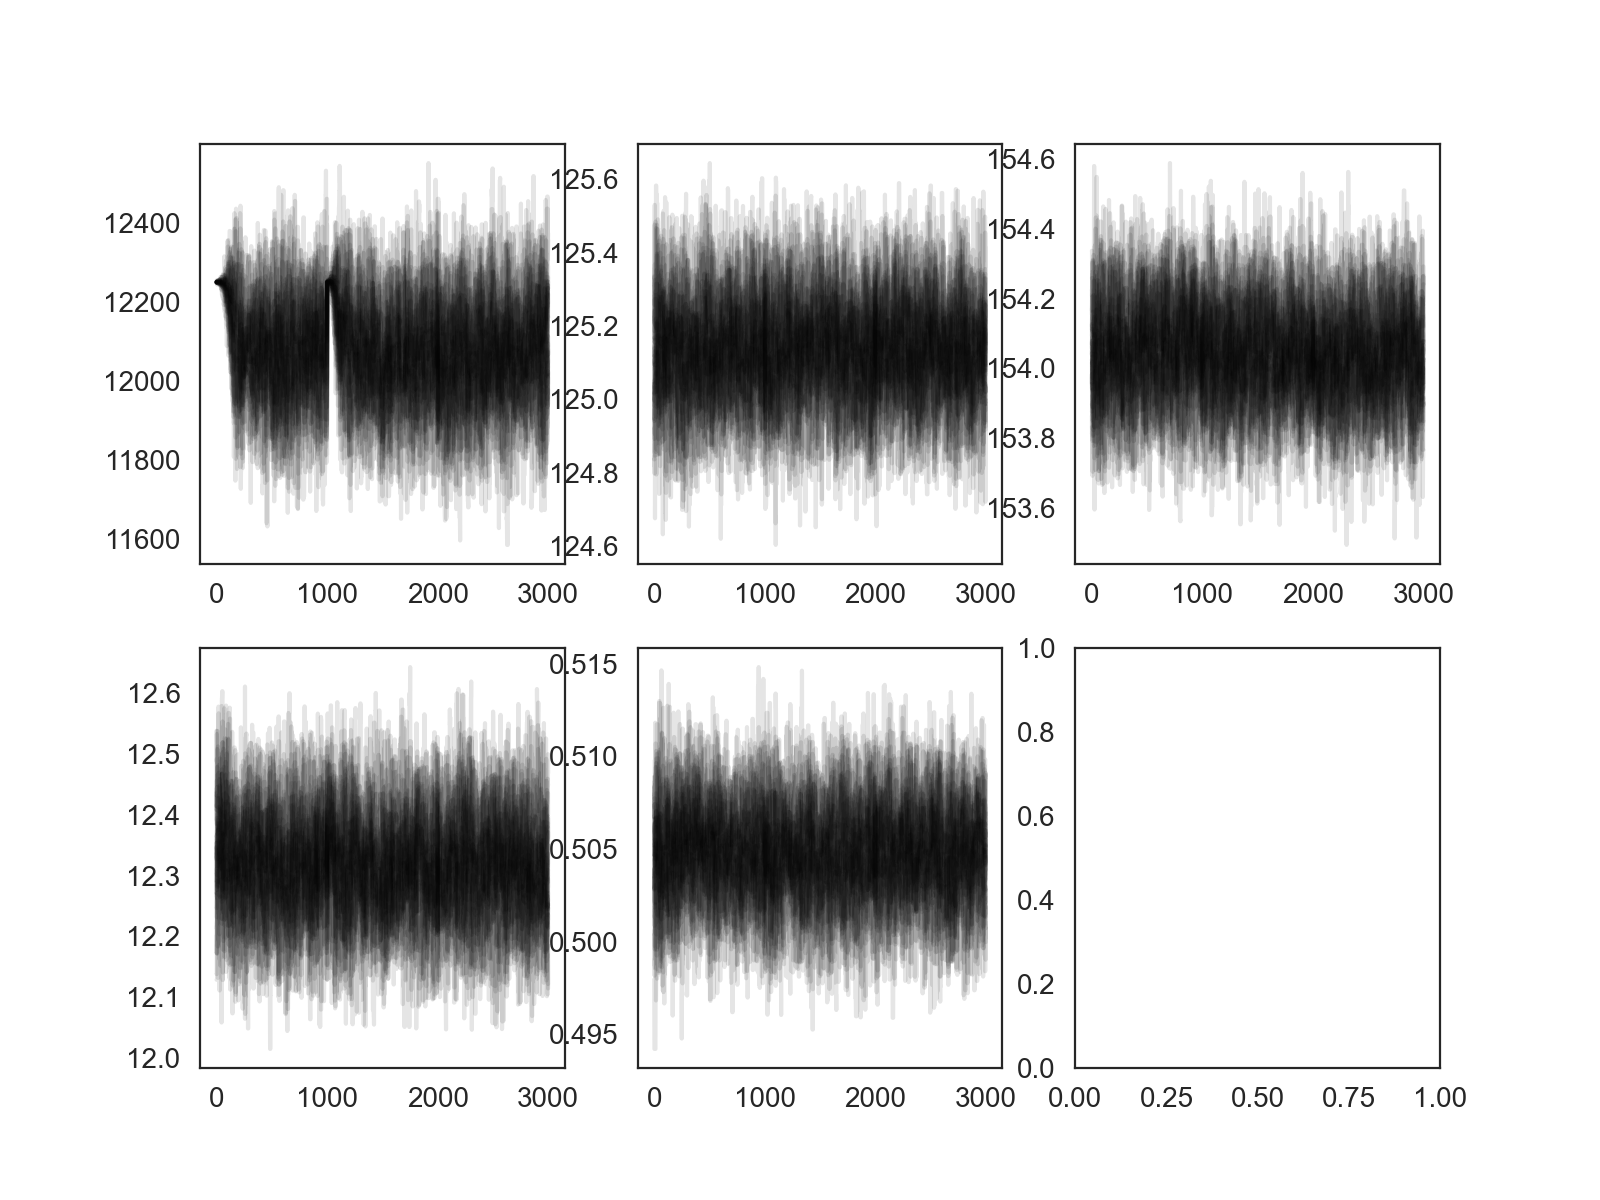

In [388]:
fig, axes = plt.subplots(2, 3, figsize=(8,6))

axes = np.hstack(axes)

for i in range(len(res.x)):
    axes[i].plot(samples[:,:,i], alpha=0.1, color="black")

There are other useful ways to check how well your chains are converged to what's hopefully the true posterior distribution (check out the reference at the start of this section for other approaches), but it's worth keeping in mind that truly knowing that this is the case is pretty much impossible in many practical applications. Depending on the structure of the posterior probability, and how and where you initialize your chains, you might entirely miss an important region of high-probability, and never know!

In [394]:
samples = sampler.get_chain(discard=2000, flat=True)

A useful way to visualize your MCMC chains is using what's called a *corner plot*. This takes your multi-dimensional distribution, and plots each dimension as a histogram, and each pair of dimensions as a contour plot. 

You can write the code to do this yourself (it's not hard), or you can use the package `corner` (install via `pip install corner`) as a convenient visualization tool:

In [395]:
import corner

<IPython.core.display.Javascript object>


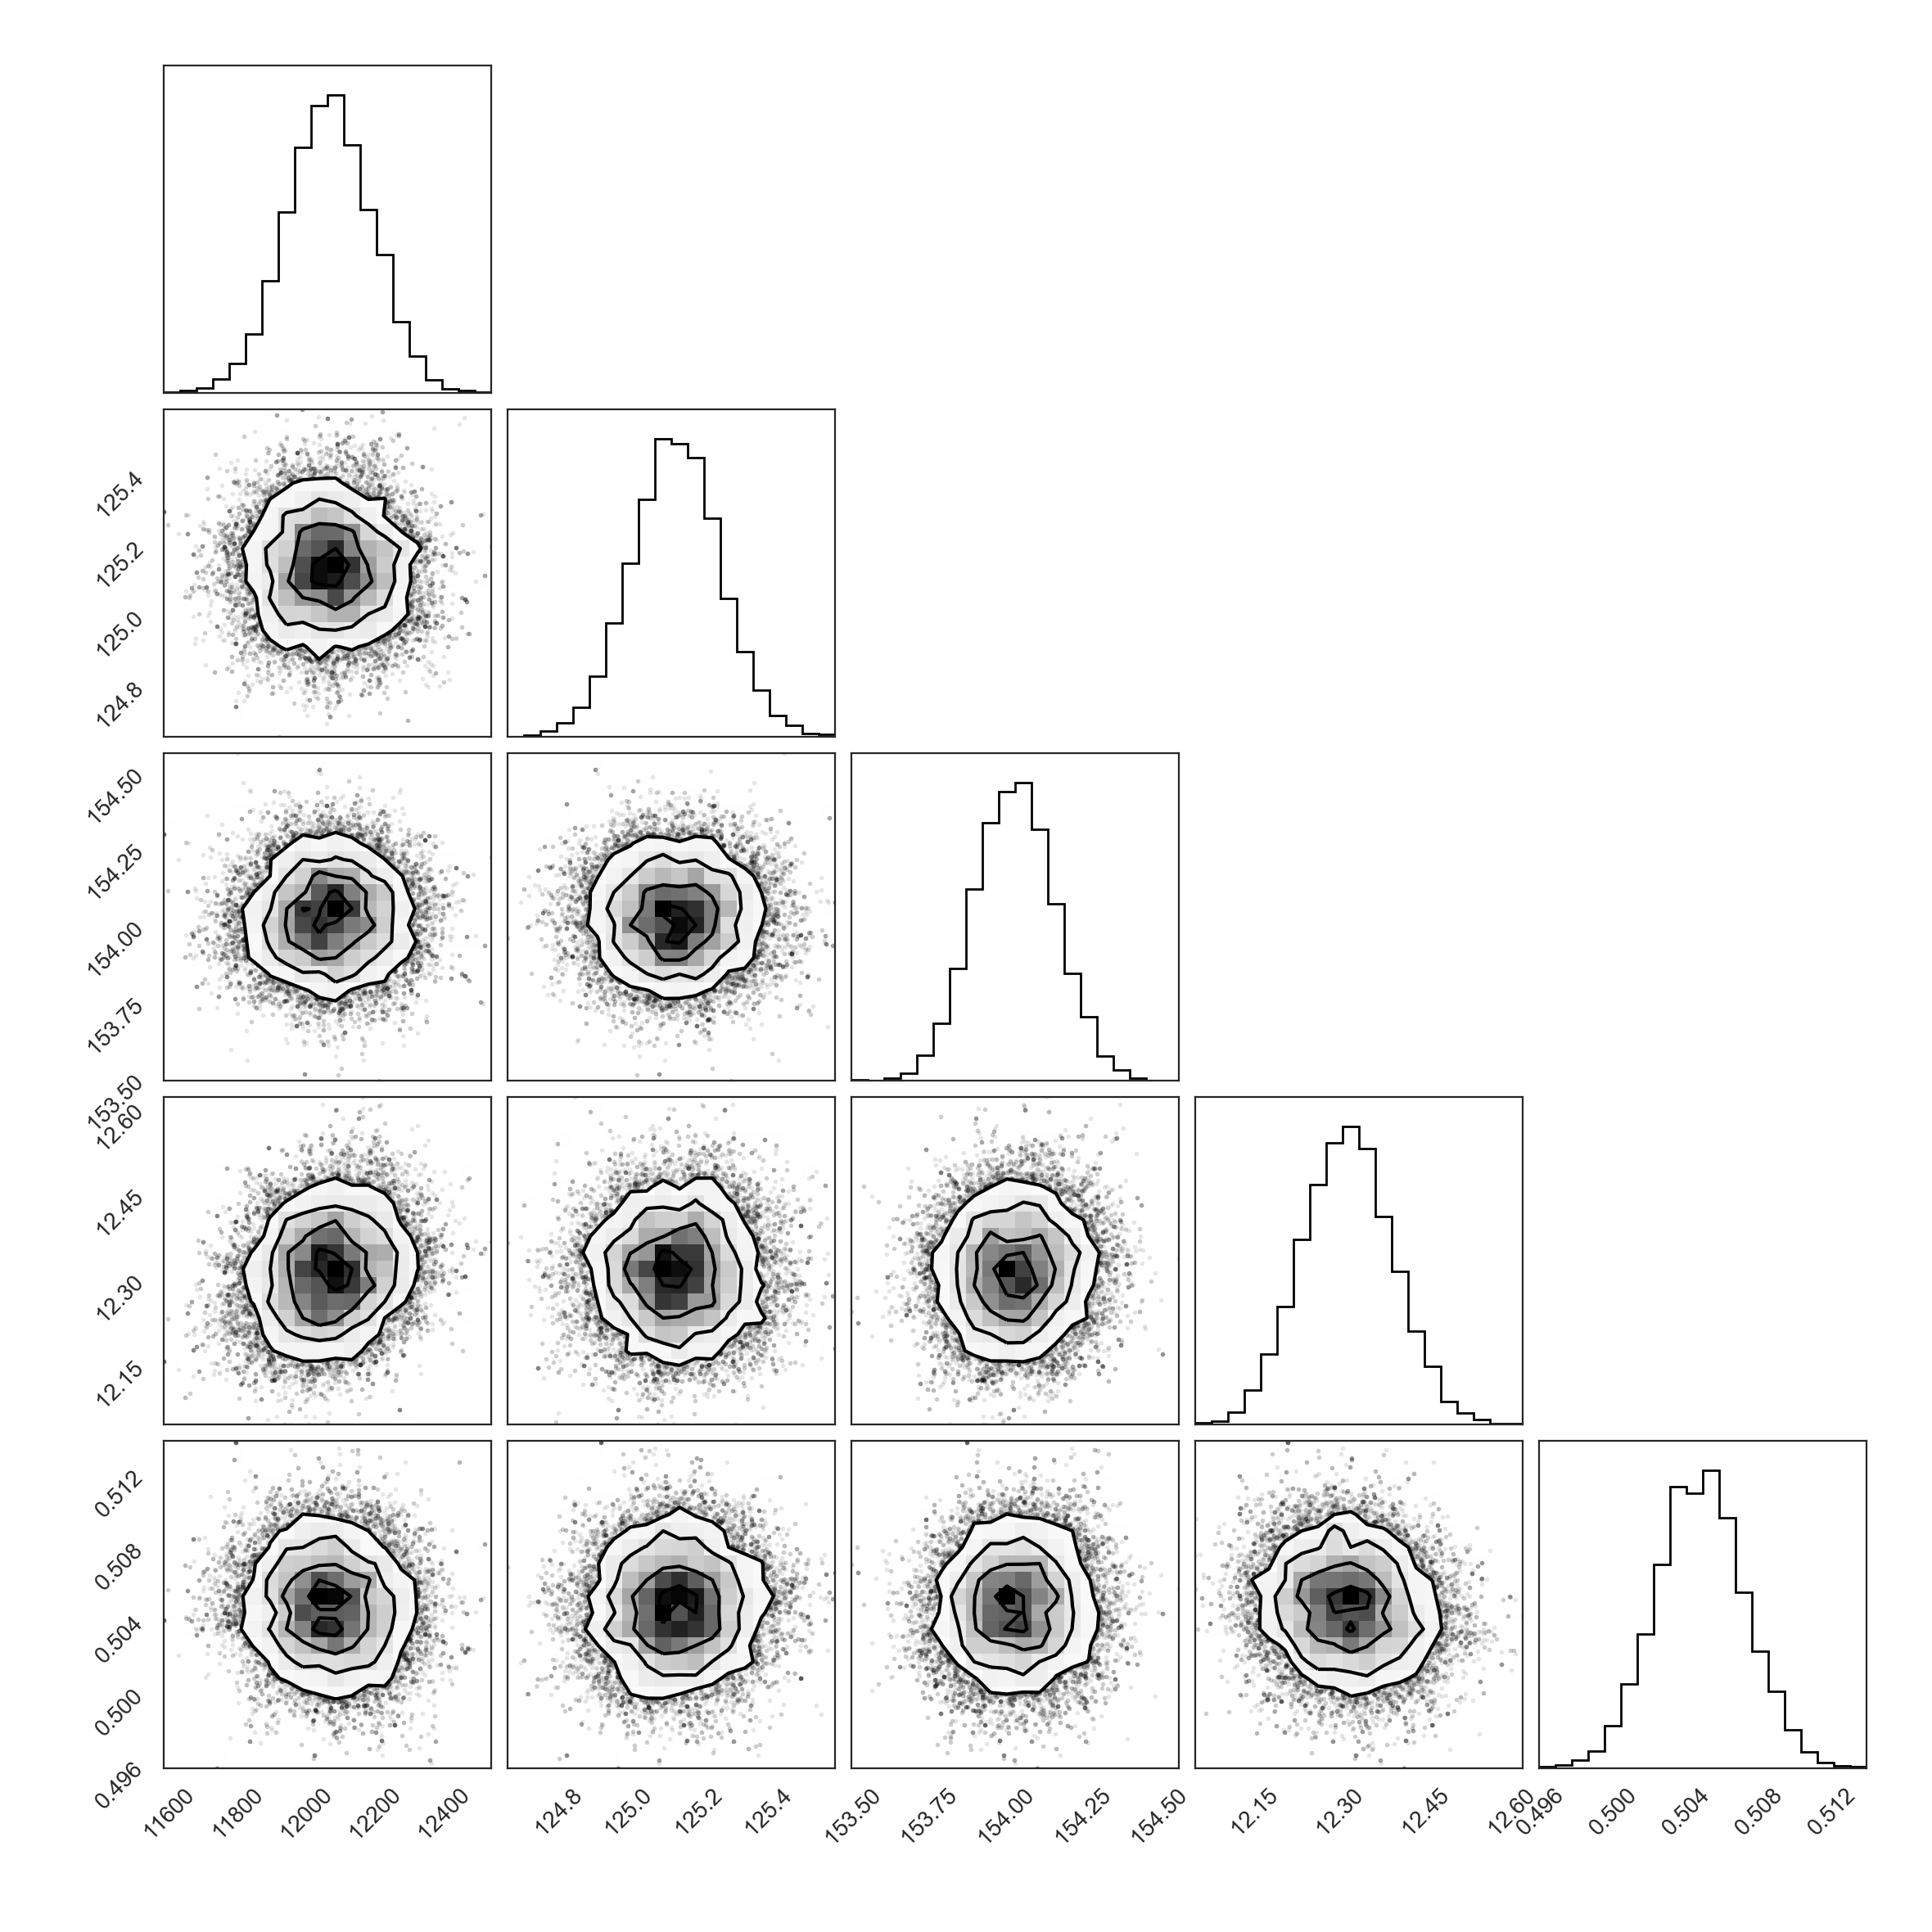

In [397]:
corner.corner(samples);

This posterior looks pretty regular and symmetric, which is nice! You can, of course, summarize this into typical mean and uncertainty estimates:

In [399]:
parameter_names = ["amplitude", "x coord", "y coord", "width", "bkg"]

for i in range(len(res.x)):
    print("%s posterior: "%parameter_names[i] + str(np.mean(samples[:,i])) + " +/- " + str(np.std(samples[:,i])))

amplitude posterior: 12066.122530770324 +/- 124.3620344223461
x coord posterior: 125.13548623729713 +/- 0.12625348393007366
y coord posterior: 154.02822713440912 +/- 0.13066378793474231
width posterior: 12.313345317281792 +/- 0.07934706730454634
bkg posterior: 0.5047560967631995 +/- 0.0024497137365554833


For problems where posteriors are asymmetric or have multiple peaks (also called *modes*), you might prefer the median and quantiles to summarize the distribution, or simply use the corner plot above as your representation of the posterior.

## Exploring (Posterior) Inference

We're not done just having found a maximum likelihood value or a posterior sample. We now have to answer the most important question: **Does our result make sense**? 

This is, of course, a complicated question to answer, and it's very dependent on the problem you're solving. 
But here are some starting questions you can ask yourselves:
* Is the likelihood function I've chosen actually appropriate for the data you have? Or did my data come from a different distribution? 
* If I take my best-fit model, or draw samples from the posterior, are the functions it generates good representations of the data I've observed? Hint: This is hard to do in 2D, so I'd recomment plotting the data and model for slices through the image.
* Is my MCMC procedure converged to the posterior?
* Do my priors make sense? Especially hard boundaries on flat priors are a very strong assumption (you're saying there's no way the parameter value could ever lie outside of those boundaries), so checking whether these make sense can be a useful way to troubleshoot.
* Where are there bugs in my code? Because there are always bugs in code. :) 
* What does my posterior look like compared to my prior? Are they close to each other? Are they far away from each other? 

**Useful Information**: If you've done model fitting in the past, you might have heard that the summed squared residuals, or $\chi^2$ divided by the degrees of freedom, should be close to 1 for the model to be a good representation. This works because for data with Gaussian uncertainties (where you use a Gaussian likelihood in your modeling), the sum of the log-likelihood for all data points is distributed following a $\chi^2$ distribution scaled by the degrees of freedom, which in turn means that if you divide by the degrees of freedom, you get a central chi-square distribution with a mean of $1$. The further away you are from that mean, the smaller the probability that your residuals were independent draws from a Gaussian distribution, which they should be if the model were exactly the true, underlying process that generated your observed data. This is a useful diagnostic for checking your model, but it only works well if your likelihood is Gaussian.

**Exercise 1**:

Do you think that your posterior inference gets close to the true parameters? Why or why not? 

**Exercise 2**:

Compare your results with some of the other groups. Are they similar? Are they very different? If they are different, can you figure out why? 